In [24]:
# All the imports
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from torch import nn, optim
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
from joblib import dump, load
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import imblearn.over_sampling 
from imblearn.over_sampling import SMOTE
import numpy as np

# read in data
df = pd.read_csv('./online_shoppers_intention.csv')
df = df.drop(['Region', 'TrafficType'], axis=1)

In [36]:
# categorical_features = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Month']
categorical_features = ['OperatingSystems', 'Browser', 'VisitorType', 'Weekend', 'Month']
numerical_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

transformers = [
    ('one_hot', OneHotEncoder(), categorical_features),
    ('robustscale', RobustScaler(), numerical_features),  # Or RobustScaler() as needed
    ('minscale', MinMaxScaler(), numerical_features)  # Or MinMaxScaler() as needed
]

preprocessor = ColumnTransformer(transformers=transformers)

x = df.drop(['Revenue'], axis=1)  # drop target
y = df['Revenue']  # Target
# y_dum = pd.get_dummies(y, prefix='rev', dtype=int)  # get_dummies for one-hot

# Apply transformations
x_preproc = preprocessor.fit_transform(x)


# Splitting the dataset into develop data and final validation comparison
x_dev, x_val, y_dev, y_val = train_test_split(x_preproc, y, test_size=0.1, random_state=42)

# Apply SMOTE Sampler algorithm to even out amount of data for development for purchases to no purchases
print("Training Development Set Revenue Freq: ")
print(y_dev.value_counts(), "\n")
smo = SMOTE()
x_os, y_os = smo.fit_resample(x_dev, y_dev)
print("Oversampled Development Data Revenue Freq: ")
print(y_os.value_counts(), "\n")

# Splitting the dataset into training and testing sets after preprocessing all data
x_train, x_test, y_train, y_test = train_test_split(x_os, y_os, test_size=0.2, random_state=42)


Training Development Set Revenue Freq: 
Revenue
False    9392
True     1705
Name: count, dtype: int64 

Oversampled Development Data Revenue Freq: 
Revenue
False    9392
True     9392
Name: count, dtype: int64 



In [37]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

# establish gradient boosting classifier
gbdt_model = GradientBoostingClassifier(n_estimators=110, learning_rate=0.02, max_depth=2, random_state=42)

gbdt_model.fit(x_train, y_train)

y_pred_gbdt = gbdt_model.predict(x_test)

# display intial test accuracy and train accuracy to spot any signs of overfitting
accuracy_gbdt_test = accuracy_score(y_test, y_pred_gbdt)
print(f'GBDT Test Model Accuracy: {accuracy_gbdt_test * 100:.2f}%')
accuracy_gbdt_train = accuracy_score(y_train, gbdt_model.predict(x_train))
print(f'GBDT Train Model Accuracy: {accuracy_gbdt_train * 100:.2f}%')
print("Classification Report : ")
print(classification_report(y_test, y_pred_gbdt))

GBDT Test Model Accuracy: 85.60%
GBDT Train Model Accuracy: 85.61%
Classification Report : 
              precision    recall  f1-score   support

       False       0.83      0.89      0.86      1877
        True       0.88      0.82      0.85      1880

    accuracy                           0.86      3757
   macro avg       0.86      0.86      0.86      3757
weighted avg       0.86      0.86      0.86      3757



In [27]:
# params to evaluate
param_distributions = {
    'n_estimators': [100, 110, 90],
    'learning_rate': [0.1, 0.02, 0.03],
    'max_depth': [2, 3, 4]  # epochs
}

gdbt_grids = GradientBoostingClassifier(random_state=42)

# set up GridSearchCV
grid_search = GridSearchCV(estimator=gdbt_grids, param_grid=param_distributions, scoring=['accuracy'], refit='accuracy', cv=15, verbose=2)

# run the grid search
grid_search.fit(x_dev, y_dev)

# report best
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_  

# Accuracy given by positive number
best_params, best_accuracy

Fitting 15 folds for each of 27 candidates, totalling 405 fits
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=2, n_

({'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 110},
 0.9063718928671567)

In [28]:
# params to evaluate
param_distributions = {
    'n_estimators': [88, 85, 89],
    'learning_rate': [0.03, 0.02, 0.04],
    'max_depth': [4, 5, 6]  # epochs
}

gdbt_grids2 = GradientBoostingClassifier(random_state=42)

# set up GridSearchCV
grid_search2 = GridSearchCV(estimator=gdbt_grids2, param_grid=param_distributions, scoring=['accuracy'], refit='accuracy', cv=15, verbose=2)

# run the grid search
grid_search2.fit(x_dev, y_dev)

# report best
best_params = grid_search2.best_params_
best_accuracy = grid_search2.best_score_  

# Accuracy given by positive number
best_params, best_accuracy

Fitting 15 folds for each of 27 candidates, totalling 405 fits
[CV] END ...learning_rate=0.03, max_depth=4, n_estimators=88; total time=   2.8s
[CV] END ...learning_rate=0.03, max_depth=4, n_estimators=88; total time=   2.8s
[CV] END ...learning_rate=0.03, max_depth=4, n_estimators=88; total time=   2.8s
[CV] END ...learning_rate=0.03, max_depth=4, n_estimators=88; total time=   2.8s
[CV] END ...learning_rate=0.03, max_depth=4, n_estimators=88; total time=   2.8s
[CV] END ...learning_rate=0.03, max_depth=4, n_estimators=88; total time=   2.8s
[CV] END ...learning_rate=0.03, max_depth=4, n_estimators=88; total time=   2.7s
[CV] END ...learning_rate=0.03, max_depth=4, n_estimators=88; total time=   2.8s
[CV] END ...learning_rate=0.03, max_depth=4, n_estimators=88; total time=   2.7s
[CV] END ...learning_rate=0.03, max_depth=4, n_estimators=88; total time=   2.7s
[CV] END ...learning_rate=0.03, max_depth=4, n_estimators=88; total time=   2.7s
[CV] END ...learning_rate=0.03, max_depth=4, n

({'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 88},
 0.9058313523266163)

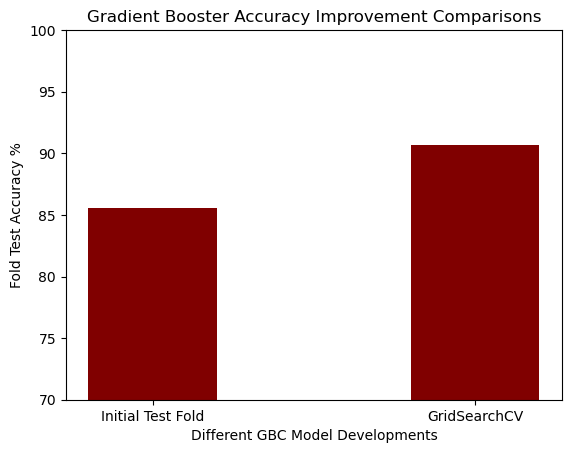

In [38]:
# Print the bar plot for accuracy comparisons with each trial of different appraoch to retrieving model
# Use best gridsearch result from the 2 trials
test_accuracies = [85.60, 90.64]
categories =['Initial Test Fold', 'GridSearchCV']
# creating the bar plot
plt.bar(categories, test_accuracies, color ='maroon', 
        width = 0.4)
plt.ylim(70, 100) 
plt.xlabel("Different GBC Model Developments")
plt.ylabel("Fold Test Accuracy %")
plt.title("Gradient Booster Accuracy Improvement Comparisons")
plt.show()

In [34]:
# test against validation data final and the best model obtained is from the first initial gridsearchcv
y_pred_val = grid_search.best_estimator_.predict(x_val)

# Print out all metrics for final validatino; mainly accuracy, f1-score, TPR, FPR 
accuracy_val = accuracy_score(y_pred_val, y_val)
print('GridSearchCV 2 Accuracy Validation: %.3f' % (accuracy_val * 100), '%')
print(classification_report(y_val, y_pred_val))
metrics_results = classification_report(y_val, y_pred_val, output_dict = True)
print('F1-Score: ', metrics_results['macro avg']['f1-score'], '\n')
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val, labels=[0, 1]).ravel()
print(confusion_matrix(y_val, y_pred_val))
print('True Positive Rate: ', tp/(tp + fn))
print('False Positive Rate: ', fp/(fp + tn))



GridSearchCV 2 Accuracy Validation: 89.213 %
              precision    recall  f1-score   support

       False       0.91      0.96      0.94      1030
        True       0.74      0.53      0.62       203

    accuracy                           0.89      1233
   macro avg       0.83      0.75      0.78      1233
weighted avg       0.88      0.89      0.88      1233

F1-Score:  0.7769746210014239 

[[993  37]
 [ 96 107]]
True Positive Rate:  0.5270935960591133
False Positive Rate:  0.035922330097087375


In [35]:
# Save the model
dump(grid_search.best_estimator_, 'gbdt_model_gscv.joblib')

['gbdt_model_gscv.joblib']